In [1]:
%matplotlib ipympl
# Import packages
import pandas as pd
import numpy as np
import datetime
import random
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from importlib import import_module
import sys

sys.path.append('../')
pf = import_module('prediction_models.genericRegressionClassification')

# Mock Dataset

In [26]:
# Define the start and end dates for the time series data
start_date = datetime.datetime(2018, 1, 1)
end_date = datetime.datetime(2019, 12, 31)
date_range = pd.date_range(start_date, end_date, freq='H')

# Create a DataFrame with cyclic patterns for temperature, humidity, and irradiance
temperature_amplitude = 30  # Amplitude of the daily temperature cycle
humidity_amplitude = 30     # Amplitude of the daily humidity cycle
irradiance_amplitude = 200  # Amplitude of the daily irradiance cycle

# Define offsets for cyclic patterns to simulate in every day
temperature_offset_daily = 3
humidity_offset_daily = -4
irradiance_offset_daily = 5

# Define offsets for the cyclic patterns to simulate different seasons
temperature_offset_yearly = 2     # Summer peak in June
humidity_offset_yearly = -2       # Summer peak in August
irradiance_offset_yearly = -3     # Summer peak in July

# noise in data
noise_std_dev = 2

data = {
    'datetime': date_range,
    'temperature': 25   + temperature_amplitude * np.sin(2 * np.pi * (date_range.hour /24) - temperature_offset_daily) \
                        + temperature_offset_yearly * np.sin(2 * np.pi * date_range.day_of_year / 365.25) \
                        + np.random.normal(scale=noise_std_dev, size=len(date_range)),

    'relative_humidity': 50 + humidity_amplitude * np.sin(2 * np.pi * (date_range.hour /24) - humidity_offset_daily) \
                            + humidity_offset_yearly * np.sin(2 * np.pi * date_range.day_of_year / 365.25) \
                            + np.random.normal(scale=noise_std_dev, size=len(date_range)),

    'irradiance': 400   + irradiance_amplitude * np.sin(2 * np.pi * (date_range.hour /24) - irradiance_offset_daily) \
                        + irradiance_offset_yearly * np.sin(2 * np.pi * date_range.day_of_year / 365.25) \
                        + np.random.normal(scale=noise_std_dev, size=len(date_range))
}

num_anomalies = 20
df = pd.DataFrame(data)

for _ in range(num_anomalies):
    timestamp = random.choice(df['datetime'])
    column = random.choice([s for s in df.columns if s!= 'datetime'])
    df.loc[df['datetime']==timestamp, column] = random.uniform(0,100)

df.set_index('datetime',inplace=True)
# df.to_csv('mock_dataset.csv')
# def dateparse(datetime):    
#     return datetime.datetime.strptime(datetime, '%Y-%m-%d %H:%M:%S')

# df = pd.read_csv('mock_dataset.csv',delimiter=',',parse_dates=['datetime'], index_col='datetime')
df.head()

,temperature,relative_humidity,irradiance
datetime,,,
2018-01-01 00:00:00,22.259557,27.436846,594.572116
2018-01-01 01:00:00,13.646672,26.603166,598.360722
2018-01-01 02:00:00,7.076436,18.989076,596.089141
2018-01-01 03:00:00,-1.842273,20.613030,573.538521
2018-01-01 04:00:00,-6.233752,20.101988,541.754541


                     temperature  relative_humidity  irradiance
datetime                                                       
2018-01-01 00:00:00    21.278611          25.038654  590.070742
2018-01-01 01:00:00    17.258375          25.720085  599.301474
2018-01-01 02:00:00     7.987039          19.904622  594.581476
2018-01-01 03:00:00    -1.561076          22.153104  577.315329
2018-01-01 04:00:00    -6.544473          18.843684  542.626863


(DatetimeIndex(['2019-07-01 00:00:00', '2019-07-01 01:00:00',
                '2019-07-01 02:00:00', '2019-07-01 03:00:00',
                '2019-07-01 04:00:00', '2019-07-01 05:00:00',
                '2019-07-01 06:00:00', '2019-07-01 07:00:00',
                '2019-07-01 08:00:00', '2019-07-01 09:00:00',
                '2019-07-01 10:00:00', '2019-07-01 11:00:00',
                '2019-07-01 12:00:00', '2019-07-01 13:00:00',
                '2019-07-01 14:00:00', '2019-07-01 15:00:00',
                '2019-07-01 16:00:00', '2019-07-01 17:00:00',
                '2019-07-01 18:00:00', '2019-07-01 19:00:00',
                '2019-07-01 20:00:00', '2019-07-01 21:00:00',
                '2019-07-01 22:00:00', '2019-07-01 23:00:00',
                '2019-07-02 00:00:00'],
               dtype='datetime64[ns]', name='datetime', freq=None),
 <Axes: xlabel='datetime'>)

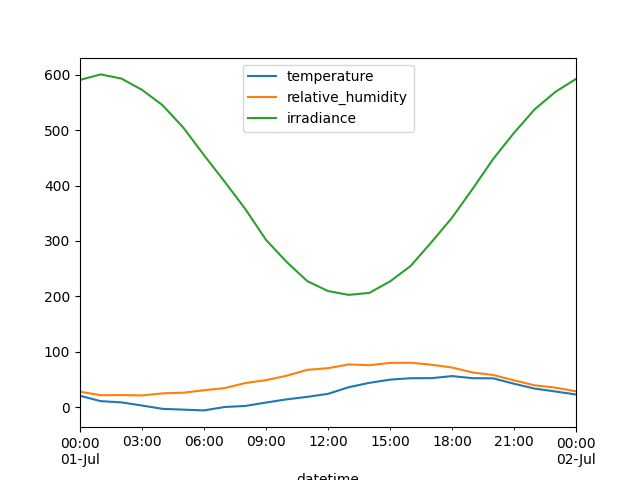

In [3]:

##################################


# Step 1: Preprocess the Data

df
df.loc[(df.index>='2019-07-01') & (df.index<='2019-07-02')].index,df.loc[(df.index>='2019-07-01')  & (df.index<='2019-07-02')].plot()


In [4]:
# Normalize the data
data = (df - df.min()) / (df.max() - df.min())

# Create sequences of 23-hour windows as input features (X) and the next hour as the target (y).
window_size = 23
X, y = [], []
for i in range(len(data) - window_size):
    X.append(data.iloc[i:i+window_size].values)
    y.append(data.iloc[i+window_size].values)
X = np.array(X)
y = np.array(y)

# Split the data into training and validation sets.
split_ratio = 0.8
split_index = int(len(X) * split_ratio)
X_train, y_train = X[:split_index], y[:split_index]
X_val, y_val = X[split_index:], y[split_index:]
print(X_train.shape)


(13979, 23, 3)


In [5]:
# Step 2: Define a PyTorch Dataset and DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

batch_size = 64
train_dataset = TimeSeriesDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Step 3: Create a Neural Network Model

class TimeSeriesModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(TimeSeriesModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

input_size = X_train.shape[-1]
hidden_size = 10
output_size = y_train.shape[-1]
model = TimeSeriesModel(input_size, hidden_size, output_size)

In [6]:
model.parameters

<bound method Module.parameters of TimeSeriesModel(
  (lstm): LSTM(3, 10, batch_first=True)
  (fc): Linear(in_features=10, out_features=3, bias=True)
)>

In [7]:
# Step 4: Train the Model
num_epochs = 10
learning_rate = 0.001
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    print('Epoch',epoch)
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        output = model(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9


In [8]:
# Step 5: Perform Predictions on the Validation Set

val_dataset = TimeSeriesDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
model.eval()
predictions = []

with torch.no_grad():
    for batch_x, _ in val_loader:
        output = model(batch_x)
        predictions.append(output)

predictions = torch.cat(predictions, dim=0)

In [9]:
# Step 6: Denormalize the Output

min_values = df.min().values
max_values = df.max().values
predictions_denormalized = (predictions * (max_values - min_values)) + min_values
y_val_denormalized = (y_val * (max_values - min_values)) + min_values
# Step 7: Assemble the Predictions into a DataFrame
predicted_df_denormalized = pd.DataFrame(predictions_denormalized.numpy(), columns=data.columns)

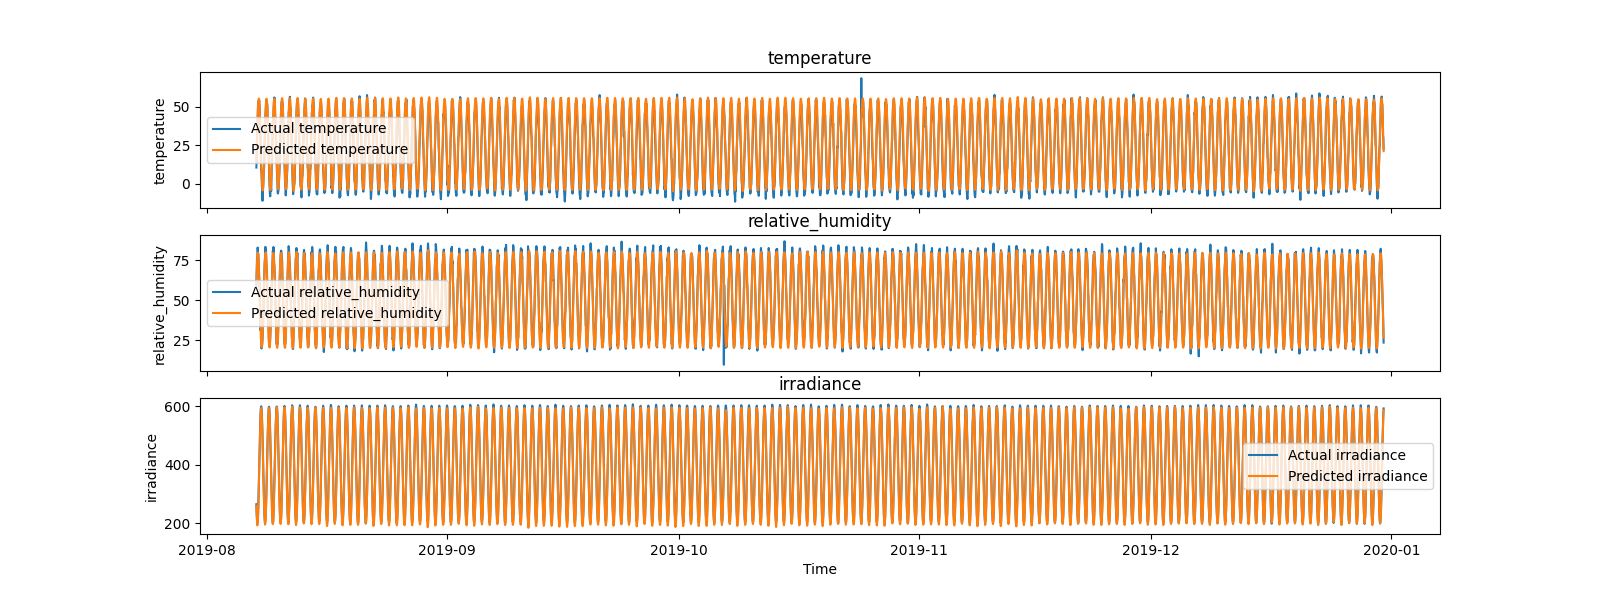

In [10]:
# Step 8: Plot and Compare Actual vs. Predicted Data
fig,axes = plt.subplots(len(data.columns),1, figsize=(16,6),sharex=True)

for i,metric in enumerate(data.columns):
    axes[i].plot(data.index[split_index+window_size:], y_val_denormalized[:,i], label=f'Actual {metric}')
    axes[i].plot(data.index[split_index+window_size:], predicted_df_denormalized.values[:,i], label=f'Predicted {metric}')
    axes[i].set_title(f'{metric}')
    axes[i].set_ylabel(metric)
    axes[i].legend()
    # for anomaly in anomaly_times:
    #     axes[i].axvline(x=anomaly, color='red')

axes[-1].set_xlabel('Time')
plt.show()

In [11]:
temperature_predicted = y_val_denormalized[:,0]
temperature_actual = predictions_denormalized.numpy()[:,0]

In [12]:
reconstruction_error = (temperature_predicted - temperature_actual)**2

bin_ranges = pd.cut(reconstruction_error, bins=50)
bin_counts = bin_ranges.value_counts().sort_index()

pd.DataFrame({
    'Bin range':bin_counts.index.astype(str),
    'Freq': bin_counts.values
})

,Bin range,Freq
0,"(-0.923, 18.457]",2821
1,"(18.457, 36.914]",528
2,"(36.914, 55.371]",110
3,"(55.371, 73.829]",25
4,"(73.829, 92.286]",9
5,"(92.286, 110.743]",0
6,"(110.743, 129.2]",0
7,"(129.2, 147.657]",0
8,"(147.657, 166.114]",0
9,"(166.114, 184.572]",0


In [13]:
threshold = np.percentile(reconstruction_error,99.5)
threshold

63.66919185860911

In [19]:
temperature_actual = y_val_denormalized[:,0]
temperature_predicted = predictions_denormalized.numpy()[:,0]
errors = np.array((temperature_predicted-temperature_actual)**2 > threshold)

In [20]:
print('Number of Anomalies',np.sum(errors))

Number of Anomalies 18


In [21]:
df_error = pd.DataFrame({
    'actual':temperature_actual,
    'predicted':temperature_predicted,
    'errors':errors
},index=data.index[split_index+window_size:])

In [22]:
df_anomalies = df_error[df_error['errors']].index

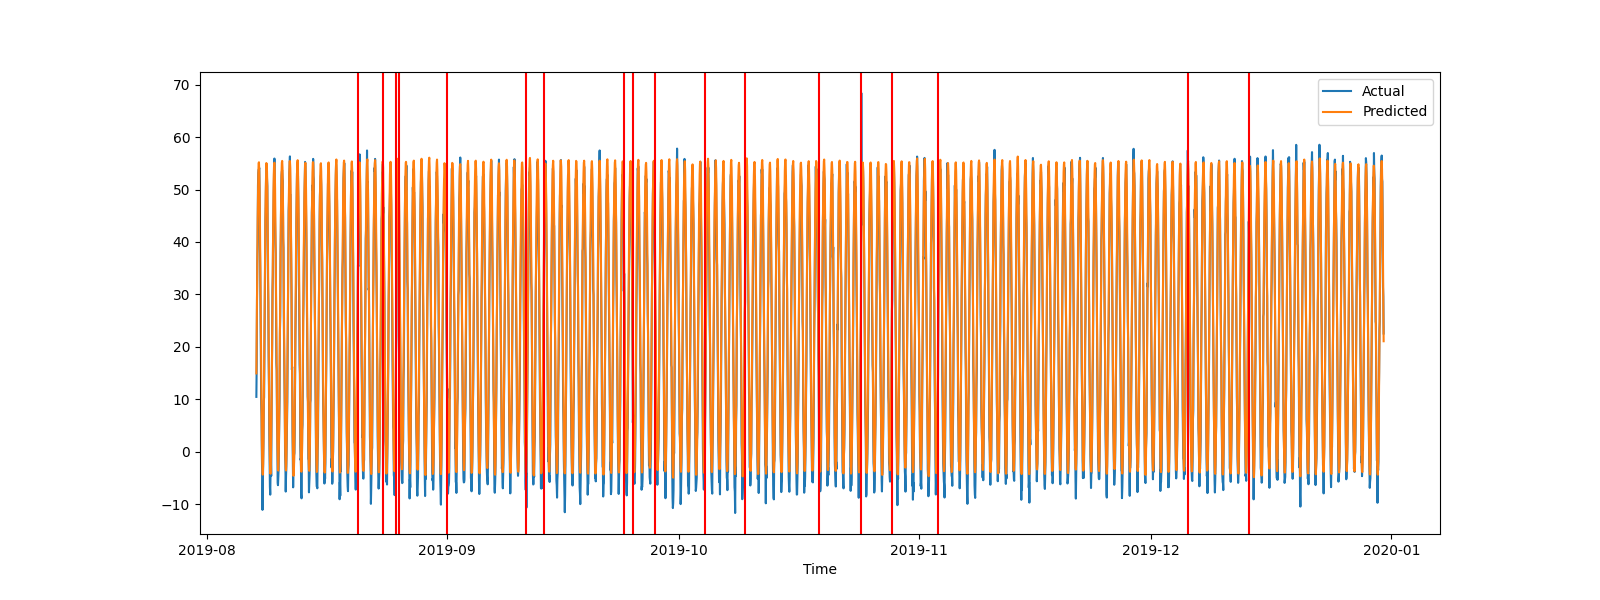

In [23]:
fig,axes = plt.subplots(1,1, figsize=(16,6),sharex=True)


axes.plot(df_error.index, df_error['actual'], label=f'Actual')
axes.plot(df_error.index, df_error['predicted'], label=f'Predicted')

for anomaly in df_anomalies:
    axes.axvline(x=anomaly, color='red')
axes.legend()
axes.set_xlabel('Time')
axes.set_title('Anomalies')
plt.show()